# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Importing packages 

Below are functions load. 

In [ ]:
# --- Core Packages ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Visualization & Dimensionality Reduction ---

from sklearn.decomposition import PCA  # Already imported later
from sklearn import datasets as ds     # Not currently used
from sklearn.manifold import TSNE
import seaborn as sns


# --- Evaluation Metrics & Model Selection ---

from sklearn import metrics
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    learning_curve,
    cross_val_score,
    cross_validate,
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    recall_score,
    precision_score
)

# --- Statistical Testing and random search ---
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, zscore, levene
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# --- Classifiers ---
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# --- Pipeline & Dimensionality Reduction ---
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# --- Scalers ---
from sklearn.preprocessing import RobustScaler

# --- Data Loading ---
from worcliver.load_data import load_data

# --- Warnings ---
import warnings


# Loading data

In [3]:
data = load_data()

# Presentation of the data:

In [4]:
# Description of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')

# Counting missing values
missing_values = data.isnull().sum()
total_missing = missing_values.sum()
print(f"Total missing values in the dataset: {total_missing}\n")


# Counting categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}\n")

# Duplicates
duplicate_count = data.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicate_count}")

# Redundant features
zero_variance_count = (data.nunique(dropna=False) == 1).sum()
print(f"Number of constant (zero variance) features: {zero_variance_count}")


# Count of each label (benign/malignant)
label_counts = data['label'].value_counts()
print("Label distribution:")
print(label_counts)


The number of samples: 186
The number of features: 494
Total missing values in the dataset: 0

Number of categorical columns: 1
Number of numerical columns: 493


Number of duplicated rows: 0
Number of constant (zero variance) features: 17
Label distribution:
label
malignant    94
benign       92
Name: count, dtype: int64


# Visualization of features

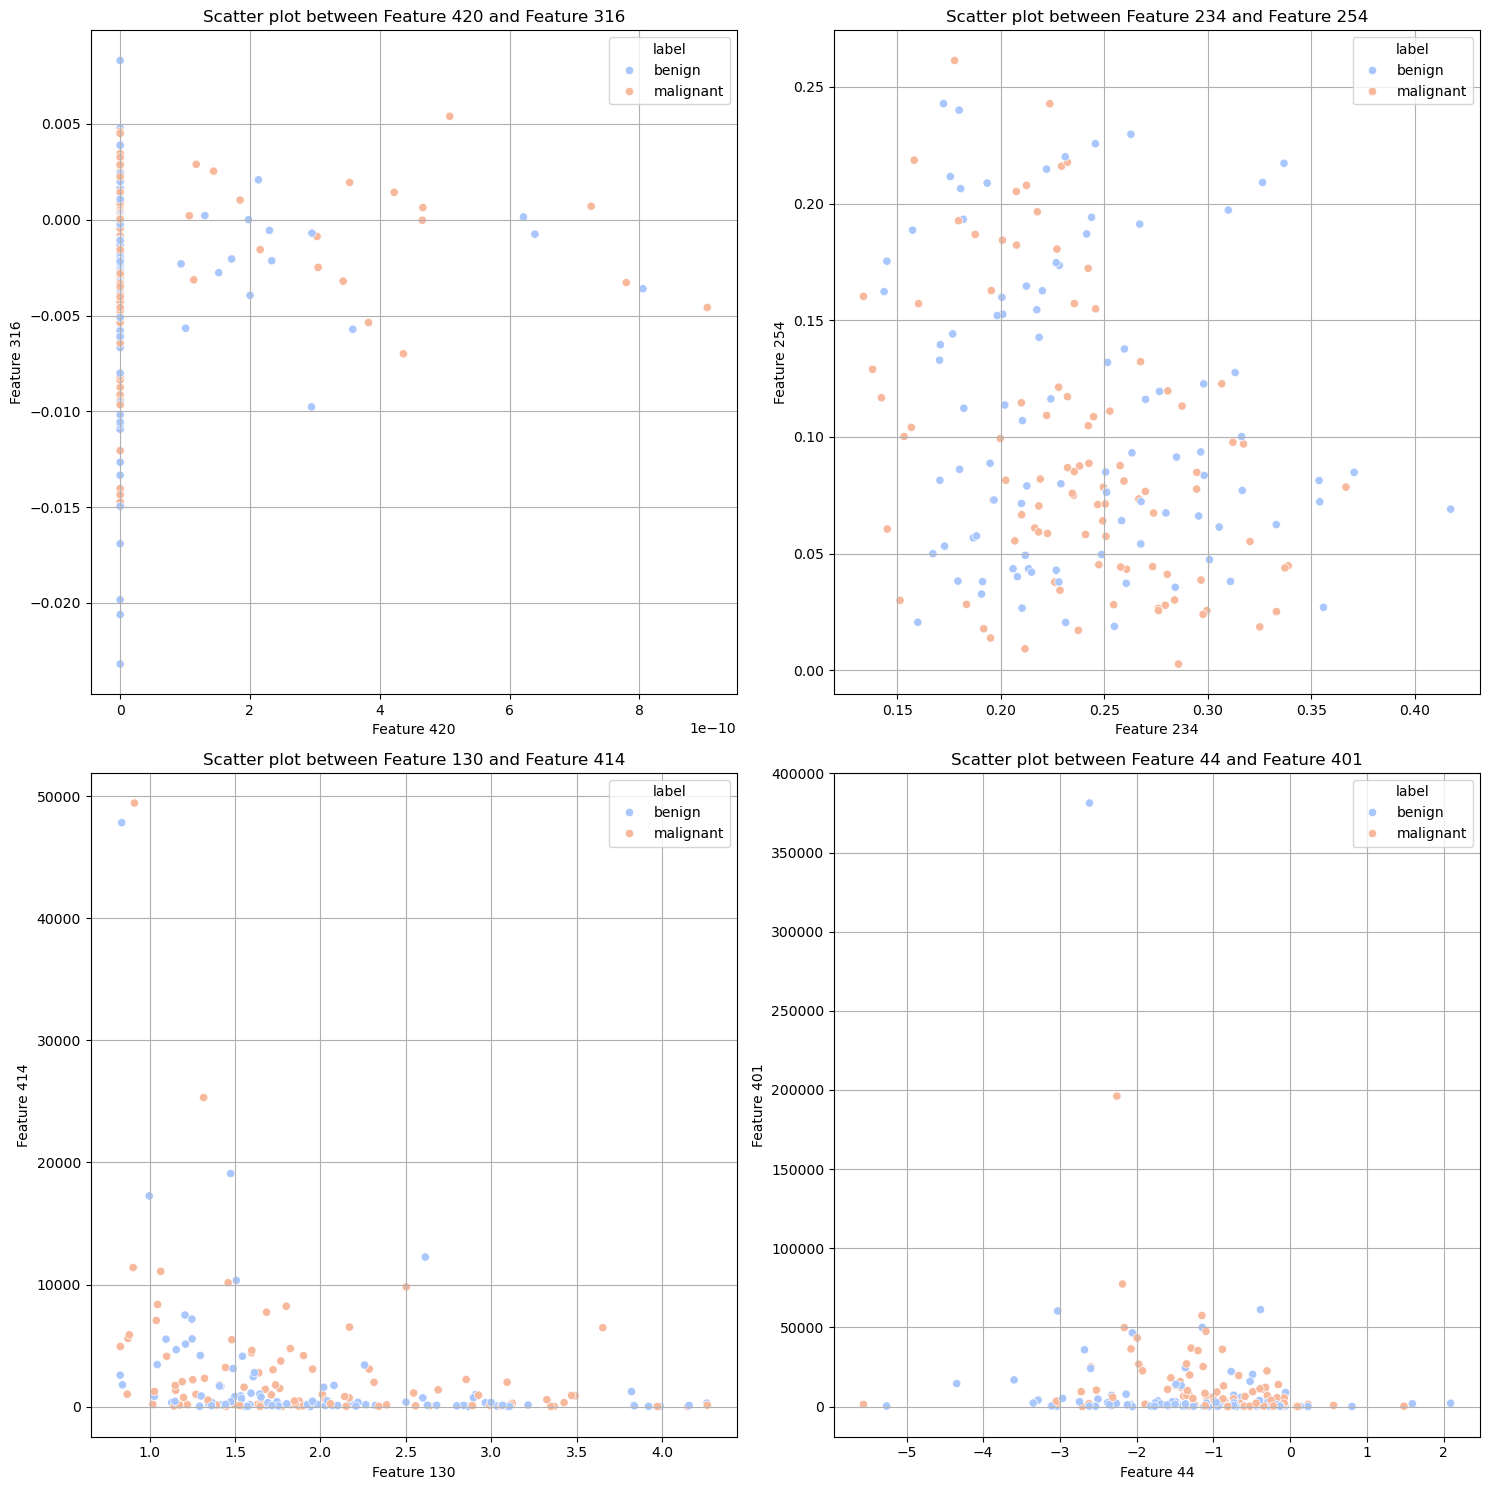

In [5]:
# For loop with a 4 subplots in which 2 features are put against eachother to visualize the data
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    # Select 2 random features, replace=false to no select a feature double
    random_state_np = np.random.default_rng(seed=i)
    random_columns = random_state_np.choice(data.columns[1:], size=2,replace=False)
    
    # Using the index number of the feature for the title, +1 to make it human readable
    feature_num1 = list(data.columns).index(random_columns[0]) + 1
    feature_num2 = list(data.columns).index(random_columns[1]) + 1
    
    ax = fig.add_subplot(2, 2, i + 1)
    sns.scatterplot(x=data[random_columns[0]], y=data[random_columns[1]], hue=data['label'], palette='coolwarm', ax=ax)
    ax.set_title(f"Scatter plot between Feature {feature_num1} and Feature {feature_num2}")
    ax.set_xlabel(f"Feature {feature_num1}")
    ax.set_ylabel(f"Feature {feature_num2}")
    ax.grid(True)

plt.tight_layout()
plt.show()


# Preprocessing & Split Dataset


In [6]:
# Copy original data and encode labels: benign → 1, malignant → 0
num_data = data.copy()
num_data['label'] = num_data['label'].map({'benign': 1, 'malignant': 0})

# Separate features
y = num_data['label']
x = num_data.drop(columns=['label'])

# Formule to split test and train data needed for final for loop
def split_test_data(x, y, random_state, test_size=0.2):
    """
    Splits the data (features x and labels y) into training and testing sets.
    
    Parameters:
    x :             The input feature set (DataFrame).
    y :             The target labels (DataFrame)
    random_state :  The seed used by the random number generator for reproducibility (int).
    test_size :     The proportion of the data to be used as the test set (float, optional (default=0.2)).

    Returns:
    x_train, x_test, y_train, y_test : The training and test splits for both features and labels (arrays).
    """
    # Splitting data into train and test sets based on the specified random state
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Printing the shape of the datasets
    print(f"The shapes of the datasets for random_state={random_state} are:")
    print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
    
    return x_train, x_test, y_train, y_test

# Train/test split (stratified to preserve label balance)
x_train, x_test, y_train, y_test = split_test_data(x, y, random_state=42, test_size=0.2)


The shapes of the datasets for random_state=42 are:
x_train: (148, 493), x_test: (38, 493)


# Checking for outliers

In [7]:
# Checking skewness in the training features 
skewness = x_train.skew()

# Identifying the highly skewed features (|skewness| > 1)
high_skew = skewness[abs(skewness) > 1] # flagging the features with skewness > 1 or < -1 (highly right- or left-skewed)
print(f"\nNumber of highly skewed features: {len(high_skew)}")

# Outlier detection using the Z-score
z_scores = np.abs(zscore(x_train))
outlier_mask_z = (z_scores > 3)

# Get features with any outliers based on the Z-score
outlier_features_z = x_train.columns[outlier_mask_z.any(axis=0)].tolist()
print(f"\nNumber of absolute high z-score features: {len(outlier_mask_z)}")

# Outlier detection using the IQR
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1
outlier_mask_iqr = ((x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR)))

# Get features with any IQR outliers
outlier_features_iqr = x_train.columns[outlier_mask_iqr.any(axis=0)].tolist()
print(f"\nNumber of features with IQR outliers: {len(outlier_features_iqr)}")



Number of highly skewed features: 253

Number of absolute high z-score features: 148

Number of features with IQR outliers: 410


C:\Users\2002k\AppData\Local\Temp\ipykernel_75564\1156101632.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(x_train))


# Selecting significant features

In [8]:
# Select significant features function needed for final for loop
def select_significant_features(x_train=x_train, y_train=y_train):
    """
    Selects statistically significant features by comparing distributions between classes.
    
    This function performs statistical testing (t-test or Mann-Whitney U-test based on normality)
    to identify features that show significant differences between classes.
    
    Parameters:
    -----------
    x_train : The training feature set. (pandas.DataFrame)
    y_train : The target labels for the training set (binary: 0 for malignant, 1 for benign). (pandas.Series or numpy.ndarray)
        
    Returns:
    --------
    x_train_sig : DataFrame with only significant features
    features_df : DataFrame with all features and their statistical test results
    sig_features_df : DataFrame with only significant features and their test results
    """
    # Add the label column back to x_train
    x_train_with_label = x_train.copy()
    x_train_with_label['label'] = y_train
    
    # Separate samples by class
    benign = x_train_with_label[x_train_with_label['label'] == 1]
    malignant = x_train_with_label[x_train_with_label['label'] == 0]
    
    # Prepare lists to store results
    features = []
    sig_features = []
    
    # Loop through all features except 'label'
    for feature in x_train_with_label.columns:
        if feature == 'label':  # Skip the label column
            continue
            
        # Data for current feature drop feature when looked at
        benign_values = benign[feature].dropna()
        malignant_values = malignant[feature].dropna()
        
        # Ignore constant values within group for Shapiro-Wilk test
        if x_train_with_label[feature].nunique() == 1:
            continue
        
        # Normality test (Shapiro-Wilk test, p < 0.05 means not normally distributed)
        _, p_shapiro = shapiro(x_train_with_label[feature])
        
        # Determine which test to use
        if p_shapiro > 0.05:
            test_type = "t-test"
            _, p_value = ttest_ind(benign_values, malignant_values, equal_var=False)  # Welch's t-test
        else:
            test_type = "Mann-Whitney U-test"
            _, p_value = mannwhitneyu(benign_values, malignant_values, alternative='two-sided')
        
        # Save results
        feature_entry = {
            "Feature": feature,
            "Test": test_type,
            "p_value": p_value
        }
        features.append(feature_entry)
        
        # Check for significance (p <= 0.05)
        if p_value <= 0.05:
            sig_entry = feature_entry.copy()
            sig_features.append(sig_entry)
    
    # Convert to DataFrames
    features_df = pd.DataFrame(features)
    sig_features_df = pd.DataFrame(sig_features)
    
    # Multiple testing correction (False Discovery Rate - Benjamini-Hochberg)
    if not features_df.empty:
        _, p_corrected, _, _ = multipletests(features_df["p_value"], method='fdr_bh')
        features_df["p_value_corrected"] = p_corrected
    
    # Sort significant features by p-value
    if not sig_features_df.empty:
        sig_features_df = sig_features_df.sort_values(by="p_value")
    
    # Amount of significant features
    print(f"\nNumber of significant features: {len(sig_features_df)}")

    # Get the list of significant feature names
    sig_feature_names = sig_features_df['Feature'].tolist() if not sig_features_df.empty else []
    
    # Select only significant features for training data
    if sig_feature_names:
        x_train_sig = x_train[sig_feature_names].copy()
    else:
        print("No significant features found. Using all features.")
        x_train_sig = x_train.copy()
    
    return x_train_sig, features_df, sig_features_df

x_train_sig, features_df, sig_features_df = select_significant_features()

# Filter x_test to contain only the same significant features as x_train_sig
x_test_sig = x_test[x_train_sig.columns]



Number of significant features: 153


# T-SNE Plot

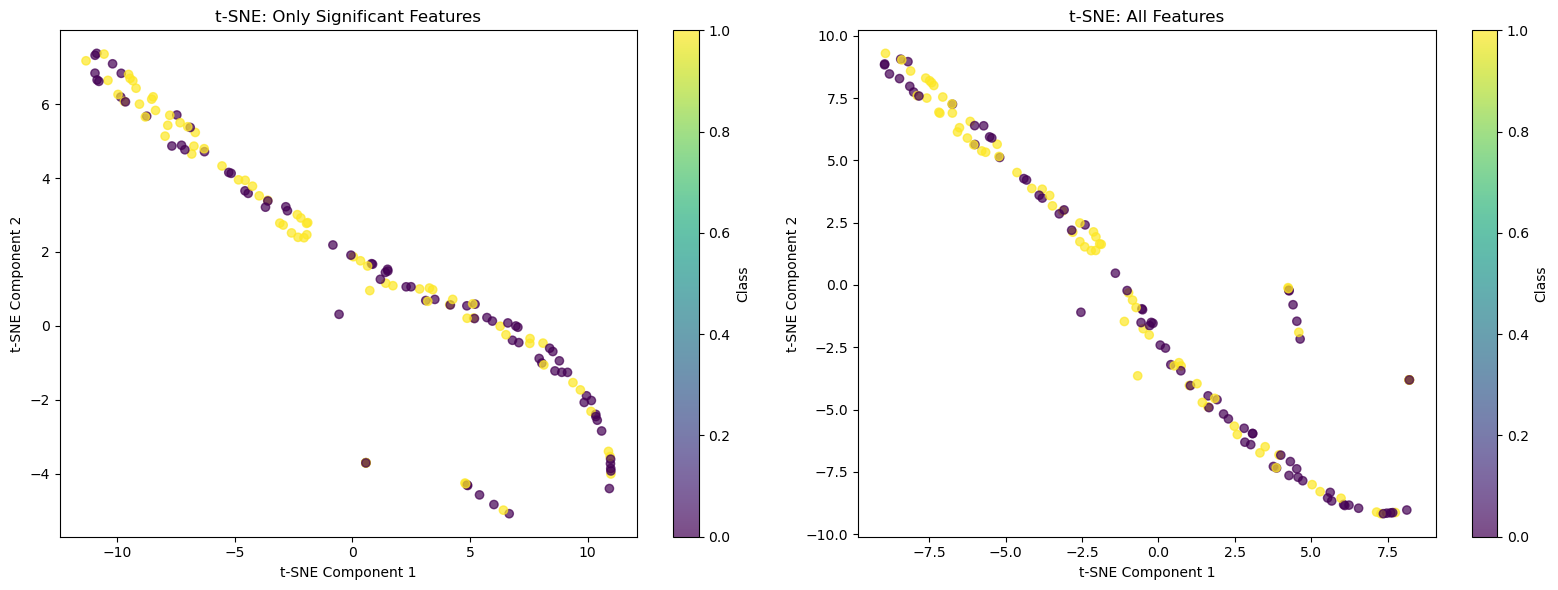

In [9]:
# t-SNE Visualization: Significant vs All Features

# t-SNE on significant the features
tsne_sig = TSNE(n_components=2, random_state=42)
x_train_tsne_sig = tsne_sig.fit_transform(x_train_sig)

# t-SNE on all the features
tsne_all = TSNE(n_components=2, random_state=42)
x_train_tsne_all = tsne_all.fit_transform(x_train)

# Plotting side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax[0].scatter(x_train_tsne_sig[:, 0], x_train_tsne_sig[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[0].set_title("t-SNE: Only Significant Features")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter1, ax=ax[0], label='Class')

scatter2 = ax[1].scatter(x_train_tsne_all[:, 0], x_train_tsne_all[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[1].set_title("t-SNE: All Features")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter2, ax=ax[1], label='Class')

plt.tight_layout()
plt.show()


# Classifiers

In [10]:
# Collect results into a list of dictionaries
results = {}

## 1. Linear Classifier (LDA)

In [11]:
#  Linear Discriminant Analysis (LDA) 

def lda_features(features_df, x_train, x_test, y, verbose=True):
    """
    Select features that satisfy the assumptions of Linear Discriminant Analysis (LDA):
    1. Normally distributed (based on t-test).
    2. Homogeneity of variance (based on Levene’s test).
    
    Parameters:
    -----------
    features_df : Output of feature significance testing, containing 'Feature' and 'Test' columns.(DataFrame)
    x_train : Training feature set. (DataFrame)
    x_test : Testing feature set.(DataFrame)
    y : Target labels (binary: 0 and 1). (Serie)
    verbose : Whether to print summary statistics. (bool)
    
    Returns:
    --------
    x_train_lda : Training data with only features valid for LDA. (DataFrame)
    x_test_lda : Testing data with only features valid for LDA. (DataFrame)
    """

    # Checking the assumption of LDA: normally distributed (t-test)
    normal_feats = features_df.loc[
        features_df['Test'] == 't-test',
        'Feature'
    ].tolist()
    
    # Check with Levene test if covariance is similar (homogeneity of variance)
    usable_feats = [
        feat for feat in normal_feats
        if levene(x_train.loc[y == 0, feat], x_train.loc[y == 1, feat])[1] > 0.05
    ]
    
    # If verbose is true print summary
    if verbose:
        print(f'Total normal distributed features: {len(normal_feats)}')
        print(f'Normal distributed and similar covariance: {len(usable_feats)}')
        print(f'Percentage usable for LDA: {len(usable_feats) / x_train.shape[1] * 100:.2f}%')
    
    # Selecting features aligned with all LDA assumptions (normality + equal covariance)
    x_train_lda = x_train[usable_feats].copy()
    x_test_lda = x_test[usable_feats].copy()
    
    return x_train_lda, x_test_lda

x_train_lda, x_test_lda=lda_features(features_df, x_train, x_test, y_train, verbose=True)

# Training and evaluating LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_lda, y_train)

# Create pipeline later needed in for loop
lda_pipeline = Pipeline([
    ('scaler', RobustScaler()), #ik doe nu een scaler maar kan evt weg? maar we doen het bij allemaal vgm
    ('classifier', LinearDiscriminantAnalysis())
])

# Prediction score
y_pred_lda = lda.predict(x_test_lda)
y_proba_lda = lda.predict_proba(x_test_lda)[:, 1]

# Storing the results of the classifier in results{}
results['Linear Discriminant Analysis'] = {
    'Classifier': 'Linear Discriminant Analysis',
    'Accuracy': accuracy_score(y_test, y_pred_lda),
    'ROC AUC': roc_auc_score(y_test, y_proba_lda),
    'F1 Score': f1_score(y_test, y_pred_lda),
    'Precision': precision_score(y_test, y_pred_lda),
    'Recall': recall_score(y_test, y_pred_lda)
}

# Print the evaluation metrics
print("\nLDA Classifier Performance:")
for metric, value in results['Linear Discriminant Analysis'].items():
    if metric != 'Classifier':
        print(f'{metric}: {value:.4f}')


Total normal distributed features: 57
Normal distributed and similar covariance: 56
Percentage usable for LDA: 11.36%

LDA Classifier Performance:
Accuracy: 0.5526
ROC AUC: 0.6787
F1 Score: 0.6531
Precision: 0.5333
Recall: 0.8421


## 2. Quadratic Classifier (QDA)

In [12]:
#  Quadratic Discriminant Analysis (QDA) 

def qda_features(features_df, x_train, x_test, y, verbose=True):
    """
    Select features that satisfy the assumptions of Quadratic Discriminant Analysis (QDA):
    1. Normally distributed (based on t-test).
    2. Distinct covariance (based on Levene’s test).
    
    Parameters:
    -----------
    features_df : Output of feature significance testing, containing 'Feature' and 'Test' columns. (DataFrame)
    x_train : Training feature set. (DataFrame)
    x_test : Testing feature set. (DataFrame)
    y : Target labels (binary: 0 and 1). (Series)
    verbose : Whether to print summary statistics. (bool)
    
    Returns:
    --------
    x_train_qda : Training data with only features valid for QDA. (DataFrame)
    x_test_qda : Testing data with only features valid for QDA. (DataFrame)
    """

    # Checking the assumption of QDA: normally distributed (t-test)
    normal_feats = features_df.loc[
        features_df['Test'] == 't-test',
        'Feature'
    ].tolist()

    # Check with Levene test if covariance is NOT similar (distinct covariance)
    usable_feats_qda = [
        feat for feat in normal_feats
        if levene(x_train.loc[y == 0, feat], x_train.loc[y == 1, feat])[1] <= 0.05
    ]

    # If verbose is true print summary
    if verbose:
        print(f'Total normal distributed features: {len(normal_feats)}')
        print(f'Normal distributed and distinct covariance: {len(usable_feats_qda)}')
        print(f'Percentage usable for QDA: {len(usable_feats_qda) / x_train.shape[1] * 100:.2f}%')

    # Selecting the features aligned with QDA assumptions (normality + distinct covariance)
    x_train_qda = x_train[usable_feats_qda].copy()
    x_test_qda = x_test[usable_feats_qda].copy()

    return x_train_qda, x_test_qda

x_train_qda, x_test_qda=qda_features(features_df, x_train, x_test, y_train, verbose=True)

# Training and evaluating the QDA classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train_qda, y_train)

# Create pipeline later needed in for loop
qda_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', QuadraticDiscriminantAnalysis())
])

# Prediction score
y_pred_qda = qda.predict(x_test_qda)
y_proba_qda = qda.predict_proba(x_test_qda)[:, 1]

# Storing the results of the classifier in results{}
results['Quadratic Discriminant Analysis'] = {
    'Classifier': 'Quadratic Discriminant Analysis',
    'Accuracy': accuracy_score(y_test, y_pred_qda),
    'ROC AUC': roc_auc_score(y_test, y_proba_qda),
    'F1 Score': f1_score(y_test, y_pred_qda),
    'Precision': precision_score(y_test, y_pred_qda),
    'Recall': recall_score(y_test, y_pred_qda)
}

# Print the evaluation metrics
print("\nQDA Classifier Performance:")
for metric, value in results['Quadratic Discriminant Analysis'].items():
    if metric != 'Classifier':
        print(f'{metric}: {value:.4f}')


Total normal distributed features: 57
Normal distributed and distinct covariance: 1
Percentage usable for QDA: 0.20%

QDA Classifier Performance:
Accuracy: 0.5000
ROC AUC: 0.6066
F1 Score: 0.3448
Precision: 0.5000
Recall: 0.2632


## 3. Naive Bayes Classifier

In [13]:
#  Naive Bayes Classifier (GaussianNB) 

def nb_features(features_df, x_train, x_test, corr_threshold=0.7, verbose=True):
    """
    Select features that satisfy the assumptions of Naive Bayes:
    1. Normally distributed (based on t-test).
    2. Low correlation (remove features with correlation above threshold).
    
    Parameters:
    -----------
    features_df : Output of feature significance testing, containing 'Feature' and 'Test' columns. (DataFrame)
    x_train : Training feature set. (DataFrame)
    x_test : Testing feature set. (DataFrame)
    corr_threshold : Threshold above which features are considered highly correlated. (float)
    verbose : Whether to print summary statistics. (bool)
    
    Returns:
    --------
    x_train_nb : Training data with only features valid for Naive Bayes. (DataFrame)
    x_test_nb : Testing data with only features valid for Naive Bayes. (DataFrame)
    """

    # Checking the assumption of Naive Bayes: normally distributed (t-test)
    normal_feats = features_df.loc[
        features_df['Test'] == 't-test',
        'Feature'
    ].tolist()

    # Remove highly correlated features among the normally distributed ones
    correlation_matrix_nb = x_train[normal_feats].corr()
    np.fill_diagonal(correlation_matrix_nb.values, np.nan)

    to_drop_nb = set()

    # loop through correlation matrix
    for i in range(len(correlation_matrix_nb.columns)):
        for j in range(i):
            # look if value in correlation matrix is bigger than correlation threshol then in to drop
            if abs(correlation_matrix_nb.iloc[i, j]) > corr_threshold:
                colname = correlation_matrix_nb.columns[i]
                to_drop_nb.add(colname)

    # Final usable features: normal + not highly correlated
    usable_feats_nb = [feat for feat in normal_feats if feat not in to_drop_nb]

    if verbose:
        print(f'Total normal distributed features: {len(normal_feats)}')
        print(f'Normal distributed and low correlation: {len(usable_feats_nb)}')
        print(f'Percentage usable for Naive Bayes: {len(usable_feats_nb) / x_train.shape[1] * 100:.2f}%')

    # Reducing the feature set accordingly
    x_train_nb = x_train[usable_feats_nb].copy()
    x_test_nb = x_test[usable_feats_nb].copy()

    return x_train_nb, x_test_nb

x_train_nb, x_test_nb = nb_features(features_df, x_train, x_test, corr_threshold=0.7, verbose=True)

# Train Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_nb, y_train)

# Create pipeline needed in for loop
nb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', GaussianNB())
])

# Predictions and probabilities
y_pred_nb = nb_classifier.predict(x_test_nb)
y_proba_nb = nb_classifier.predict_proba(x_test_nb)[:, 1]

# Store results in results{}
results['Naive Bayes'] = {
    'Classifier': 'Naive Bayes',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'ROC AUC': roc_auc_score(y_test, y_proba_nb),
    'F1 Score': f1_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb)
}

# Print the evaluation metrics
print("\nNaive Bayes Classifier Performance:")
for metric, value in results['Naive Bayes'].items():
    if metric != 'Classifier':
        print(f'{metric}: {value:.4f}')


Total normal distributed features: 57
Normal distributed and low correlation: 16
Percentage usable for Naive Bayes: 3.25%

Naive Bayes Classifier Performance:
Accuracy: 0.6316
ROC AUC: 0.7008
F1 Score: 0.6667
Precision: 0.6087
Recall: 0.7368


## 4. k-NN Classifier

Best Parameters: {'pca__n_components': 8, 'knn__weights': 'uniform', 'knn__n_neighbors': 15, 'knn__metric': 'minkowski'}
Test Accuracy: 0.4737


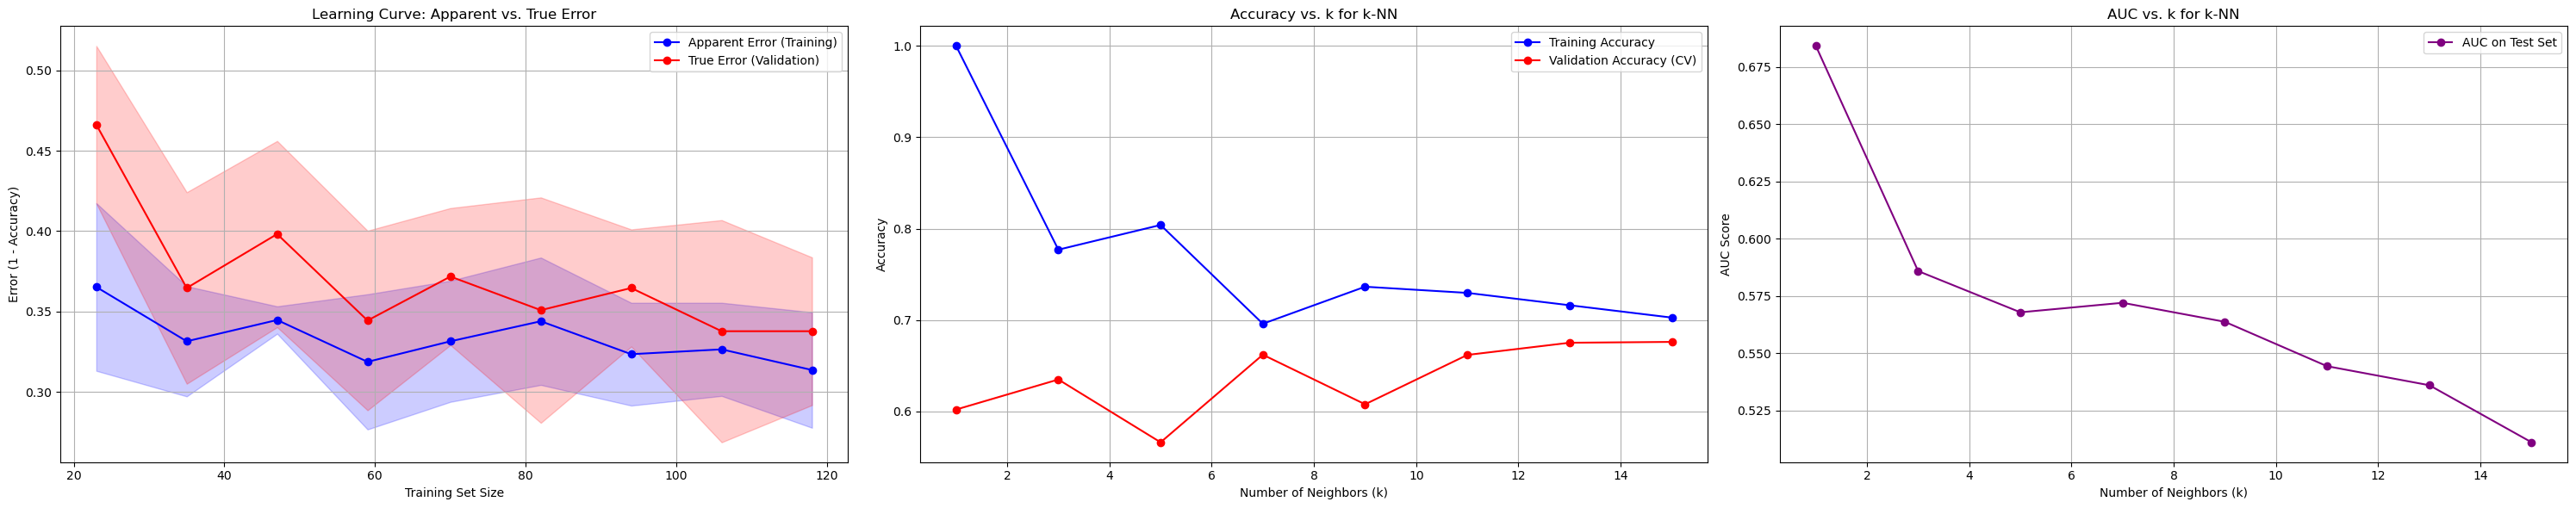

In [14]:
# Making the K-NN classifier 

warnings.filterwarnings("ignore")
# Define the pipeline for kNN
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid kNN
param_grid = {
    'pca__n_components': [2, 4, 6, 8, 10],
    'knn__n_neighbors': list(range(1, 17, 2)),  # Odd k values from 1 to 15
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform hyperparameter optimization
random_grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_grid_search.fit(x_train_sig, y_train)

# Best model evaluation
best_model = random_grid_search.best_estimator_
y_pred = best_model.predict(x_test_sig)
test_accuracy = accuracy_score(y_test, y_pred)

# Print best parameters and test accuracy
print(f"Best Parameters: {random_grid_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.4f}")

#  Storing the k-NN results in results dictionary 

# Predict probabilities for ROC AUC
y_proba_knn = best_model.predict_proba(x_test_sig)[:, 1]

# Store metrics
results['k-NN'] = {
    'Classifier': 'k-Nearest Neighbors',
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba_knn),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
}

#  Evaluation of the k-NN classifier

# PLOT 1: Learning Curve (Apparent vs. True Error)
best_k = random_grid_search.best_params_['knn__n_neighbors']
best_pca = random_grid_search.best_params_['pca__n_components']

# Defining the final (best) pipeline
kn_pipeline = Pipeline([
    ('scaler', RobustScaler()),  
    ('pca', PCA(n_components=best_pca)),  
    ('knn', KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform'))
])

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    kn_pipeline, x_train_sig, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Computing the mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Converting accuracy to error (1 - accuracy)
train_error = 1 - train_mean
val_error = 1 - val_mean

# PLOT 2: Accuracy vs. k and ROC AUC vs. k
k_values = list(range(1, 17, 2))
train_accuracies = []
val_accuracies = []
auc_scores = []

for k in k_values:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=best_pca)),  
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform'))
    ])
    
    # Cross-validation accuracy
    val_score = cross_val_score(pipeline, x_train_sig, y_train, cv=5, scoring='accuracy').mean()
    val_accuracies.append(val_score)

    # Train accuracy
    pipeline.fit(x_train_sig, y_train)
    train_pred = pipeline.predict(x_train_sig)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_acc)

    # ROC AUC on test set
    try:
        y_proba = pipeline.predict_proba(x_test_sig)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
    except:
        auc_score = np.nan
    auc_scores.append(auc_score)

# Create a figure with 3 subplots next to each other (use the original comments and structure)
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

# PLOT 1: Learning Curve (Apparent vs. True Error)
axes[0].plot(train_sizes, train_error, marker='o', color='blue', label='Apparent Error (Training)')
axes[0].plot(train_sizes, val_error, marker='o', color='red', label='True Error (Validation)')
axes[0].fill_between(train_sizes, train_error - train_std, train_error + train_std, color='blue', alpha=0.2)
axes[0].fill_between(train_sizes, val_error - val_std, val_error + val_std, color='red', alpha=0.2)
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('Error (1 - Accuracy)')
axes[0].set_title('Learning Curve: Apparent vs. True Error')
axes[0].legend()
axes[0].grid(True)

# PLOT 2: Accuracy vs. k for k-NN
axes[1].plot(k_values, train_accuracies, marker='o', label='Training Accuracy', color='blue')
axes[1].plot(k_values, val_accuracies, marker='o', label='Validation Accuracy (CV)', color='red')
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs. k for k-NN')
axes[1].legend()
axes[1].grid(True)

# PLOT 3: AUC vs. k for k-NN
axes[2].plot(k_values, auc_scores, marker='o', label='AUC on Test Set', color='purple')
axes[2].set_xlabel('Number of Neighbors (k)')
axes[2].set_ylabel('AUC Score')
axes[2].set_title('AUC vs. k for k-NN')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 5. Hard support vector machine

In [ ]:
# Support vector machine (hard)

svm_hard_pipeline = Pipeline([
    ('scaler', RobustScaler()), #robust scaler because of outliners 
    ('svm', LinearSVC(C=100, max_iter=100000, random_state=42))
])

validation_svm_linear = cross_val_score(svm_hard_pipeline, x_train, y_train, cv=5)

svm_hard_model = LinearSVC(C=100, max_iter=100000, random_state=42)
svm_hard_model.fit(x_train_sig,y_train)

y_pred_svm_hard = svm_hard_model.predict(x_test[x_train_sig.columns])

# SVM does not support probability by default unless explicitly set so wee need decision function for ROC
try:
    y_scores_svm_hard = svm_hard_model.decision_function(x_test[x_train_sig.columns])
    roc_svm_hard = roc_auc_score(y_test, y_scores_svm_hard)
except:
    roc_svm_hard = np.nan

# Storing the results
results["Support Vector Machine Hard"] = {
    'Classifier': 'Support Vector Machine Hard',
    'Accuracy': accuracy_score(y_test, y_pred_svm_hard),
    'ROC AUC': roc_svm_hard,
    'F1 Score': f1_score(y_test, y_pred_svm_hard),
    'Precision': precision_score(y_test, y_pred_svm_hard),
    'Recall': recall_score(y_test, y_pred_svm_hard)
}

# Print the evaluation metrics
print("\nSupport Vector Machine Hard Performance:")
for metric, value in results["Support Vector Machine Hard"].items():
    if metric != 'Classifier':
        print(f'{metric}: {value:.4f}')
#Warning: failed to converge, not usuable 



Support Vector Machine Hard Performance:
Accuracy: 0.5000
ROC AUC: 0.5706
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


## 6.1 Soft Margin Support Vector Machine

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best CV Score: 0.7796825396825396
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 SVC(C=np.float64(1.0), coef0=0.75, degree=2, kernel='linear',
                     random_state=42))])
Best Parameters: {'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__degree': 2, 'classifier__coef0': 0.75, 'classifier__C': np.float64(1.0)}


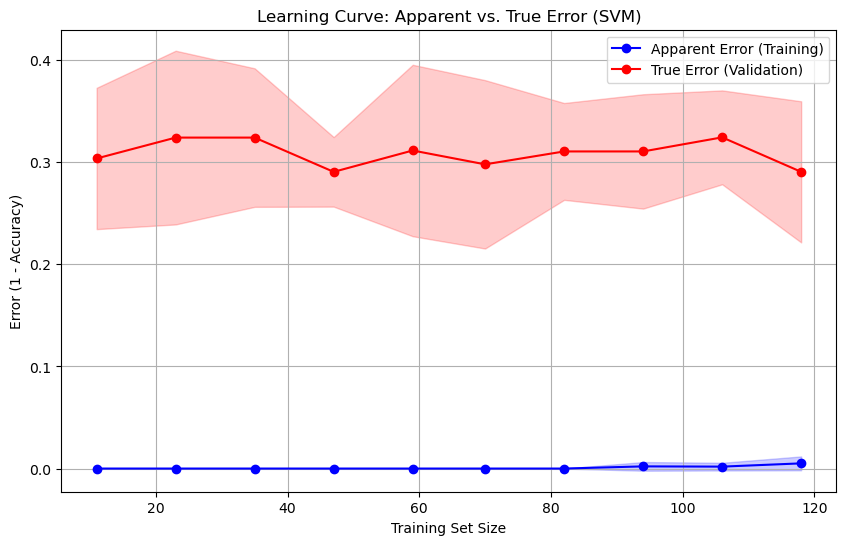

In [16]:
#soft margin SVM, search for the best hyperparameters

# Create a pipeline: first scaling, then the SVM classifier
svm_soft_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', SVC(random_state=42))
])

param_distributions = {
    'classifier__C': np.logspace(-3, 2, 6),                #log scale for plot
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],                 # Relevant for rbf, poly, and sigmoid kernels
    'classifier__degree': [2, 3, 4, 5],                     # Only relevant when kernel='poly'
    'classifier__coef0': np.linspace(0, 1, 5).tolist()      # Only relevant for poly and sigmoid kernels
}

# Loop over different values for hyperparameters
svm_search = RandomizedSearchCV(
    estimator=svm_soft_pipeline,
    param_distributions=param_distributions,
    n_iter=15,       # How many combinations of hyperparameters 
    cv=5,            # 5-fold cross-validation
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    refit=True,
    n_jobs=-1
)

# Execute the Randomized Search on the training data (using only significant features)
svm_search.fit(x_train_sig, y_train)

# Print results
print("Best CV Score:", svm_search.best_score_)
print("Best Estimator:", svm_search.best_estimator_)
print("Best Parameters:", svm_search.best_params_)


# Getting the best parameters from svm_search 
best_params = svm_search.best_params_
best_C = best_params['classifier__C']
best_kernel = best_params['classifier__kernel']
best_gamma = best_params['classifier__gamma']
best_degree = best_params['classifier__degree']
best_coef0 = best_params['classifier__coef0']

final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma,
    degree=best_degree, coef0=best_coef0, random_state=42)

# Building the final pipeline
final_pipeline_soft_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model)
])

## Plot learning curve 
train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline_soft_svm, x_train_sig, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Converting accuracy to the error
train_error = 1 - train_mean
val_error = 1 - val_mean

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
plt.plot(train_sizes, val_error, marker='o', label='True Error (Validation)', color='red')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error (SVM)')
plt.legend()
plt.grid(True)
plt.show()

## 6.2 SVM with regulation 

The soft SVM above is overfitting. So regulation, as wel L1 and L2 is tested.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV Score (ROC AUC): 0.8691428571428572
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 LinearSVC(C=np.float64(0.8531678524172814), dual=False,
                           max_iter=10000, penalty='l1', random_state=42,
                           tol=0.001))])
Best Parameters: {'classifier__C': np.float64(0.8531678524172814)}
Training ROC AUC: 0.9948858447488584
Accuracy validation svm: [0.86666667 0.76666667 0.66666667 0.68965517 0.79310345]
Difference training & validation accuracy: 0.2383341206109274


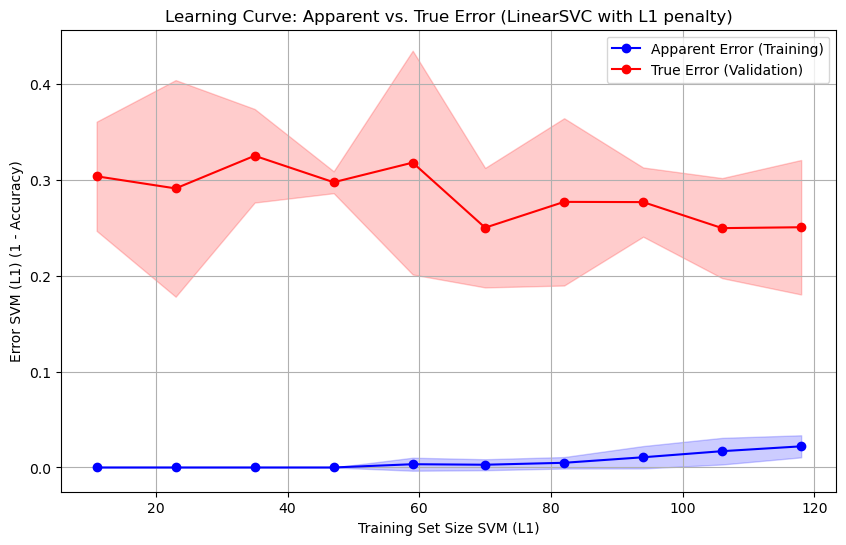

In [17]:
#Soft margin SVM met LinearSVC en L1 penalty

warnings.filterwarnings("ignore")
# Pipeline: scaling + LinearSVC
svm_l1_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=1e-3, max_iter=10000, random_state=42))
])

# Hyperparameter distribution for LinearSVC
param_distributions = {
    'classifier__C': np.logspace(-3, 2, 30)  # log-schaal van 0.001 t/m 100
}

# Randomized Search met cross-validation
svm_search = RandomizedSearchCV(
    estimator=svm_l1_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    refit=True,
    n_jobs=-1
)

# Fit on trainingsdata
svm_search.fit(x_train_sig, y_train)

# Results
print("Best CV Score (ROC AUC):", svm_search.best_score_)
print("Best Estimator:", svm_search.best_estimator_)
print("Best Parameters:", svm_search.best_params_)

# Analysis on overfitting
train_score_svm = svm_search.score(x_train_sig, y_train)  # roc auc on traindata 
print(f"Training ROC AUC: {train_score_svm}")

validation_accuracy_svm = cross_val_score(svm_search.best_estimator_, x_train_sig, y_train, scoring='accuracy', cv=5)
print("Accuracy validation svm:", validation_accuracy_svm)
print(f"Difference training & validation accuracy: {train_score_svm - np.mean(validation_accuracy_svm)}")

# Final model
best_C = svm_search.best_params_['classifier__C']

final_model_l1 = LinearSVC(C=best_C, penalty='l1', loss='squared_hinge', dual=False, tol=1e-3, max_iter=10000, random_state=42)

final_pipeline_l1 = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model_l1)
])

# PLOT 1: Learning Curve (Apparent vs. True Error)
train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline_l1, x_train_sig, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

train_error = 1 - train_mean
val_error = 1 - val_mean

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
plt.plot(train_sizes, val_error, marker='o', label='True Error (Validation)', color='red')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size SVM (L1)')
plt.ylabel('Error SVM (L1) (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error (LinearSVC with L1 penalty)')
plt.legend()
plt.grid(True)
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV Score (ROC AUC): 0.8407619047619047
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 LinearSVC(C=np.float64(0.007278953843983154), dual=True,
                           max_iter=10000, random_state=42, tol=0.001))])
Best Parameters: {'classifier__C': np.float64(0.007278953843983154)}
Training ROC AUC SVM (L2): 0.9656621004566209
Accuracy validation SVM (L2): [0.83333333 0.8        0.63333333 0.75862069 0.82758621]
Difference training & validation accuracy SVM (L2): 0.19508738781294277


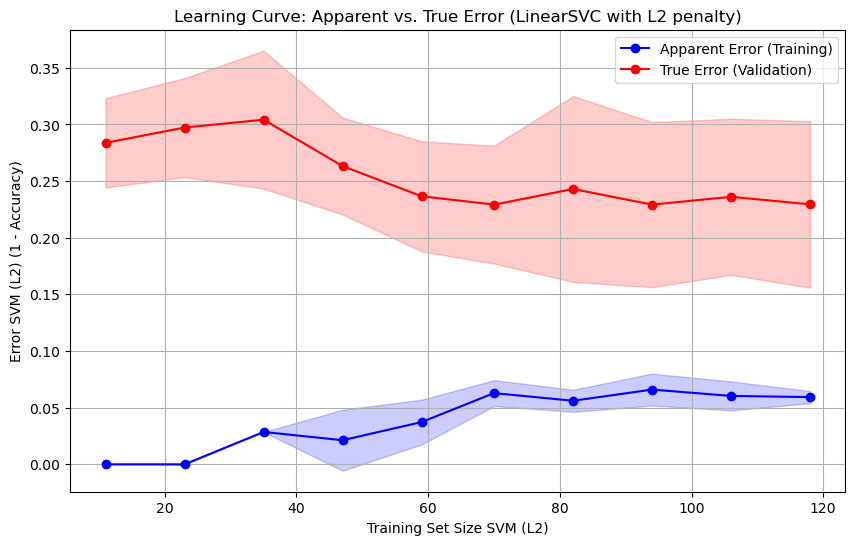

In [18]:
# L2
# Soft margin SVM met LinearSVC en L2 penalty
warnings.filterwarnings("ignore")

# Pipeline
svm_l2_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=1e-3, max_iter=10000, random_state=42))
])

# Hyperparameter distribution
param_distributions = {
    'classifier__C': np.logspace(-3, 2, 30)  # C in log-scale from  0.001 - 100
}

# Randomized Search
svm_search = RandomizedSearchCV(
    estimator=svm_l2_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    refit=True,
    n_jobs=-1
)

# Fit on train data
svm_search.fit(x_train_sig, y_train)

# Results
print("Best CV Score (ROC AUC):", svm_search.best_score_)
print("Best Estimator:", svm_search.best_estimator_)
print("Best Parameters:", svm_search.best_params_)

# Analysis on overfitting
train_score_svm = svm_search.score(x_train_sig, y_train)
print(f"Training ROC AUC SVM (L2): {train_score_svm}")

validation_accuracy_svm = cross_val_score(svm_search.best_estimator_, x_train_sig, y_train, scoring='accuracy', cv=5)
print("Accuracy validation SVM (L2):", validation_accuracy_svm)
print(f"Difference training & validation accuracy SVM (L2): {train_score_svm - np.mean(validation_accuracy_svm)}")

# Final model
best_C = svm_search.best_params_['classifier__C']
final_model_l2 = LinearSVC(C=best_C, penalty='l2', loss='squared_hinge', dual=True, tol=1e-3, max_iter=10000, random_state=42)

final_pipeline_l2 = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model_l2)
])

# PLOT 1: Learning Curve 
train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline_l2, x_train_sig, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

train_error = 1 - train_mean
val_error = 1 - val_mean

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
plt.plot(train_sizes, val_error, marker='o', label='True Error (Validation)', color='red')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size SVM (L2)')
plt.ylabel('Error SVM (L2) (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error (LinearSVC with L2 penalty)')
plt.legend()
plt.grid(True)
plt.show()

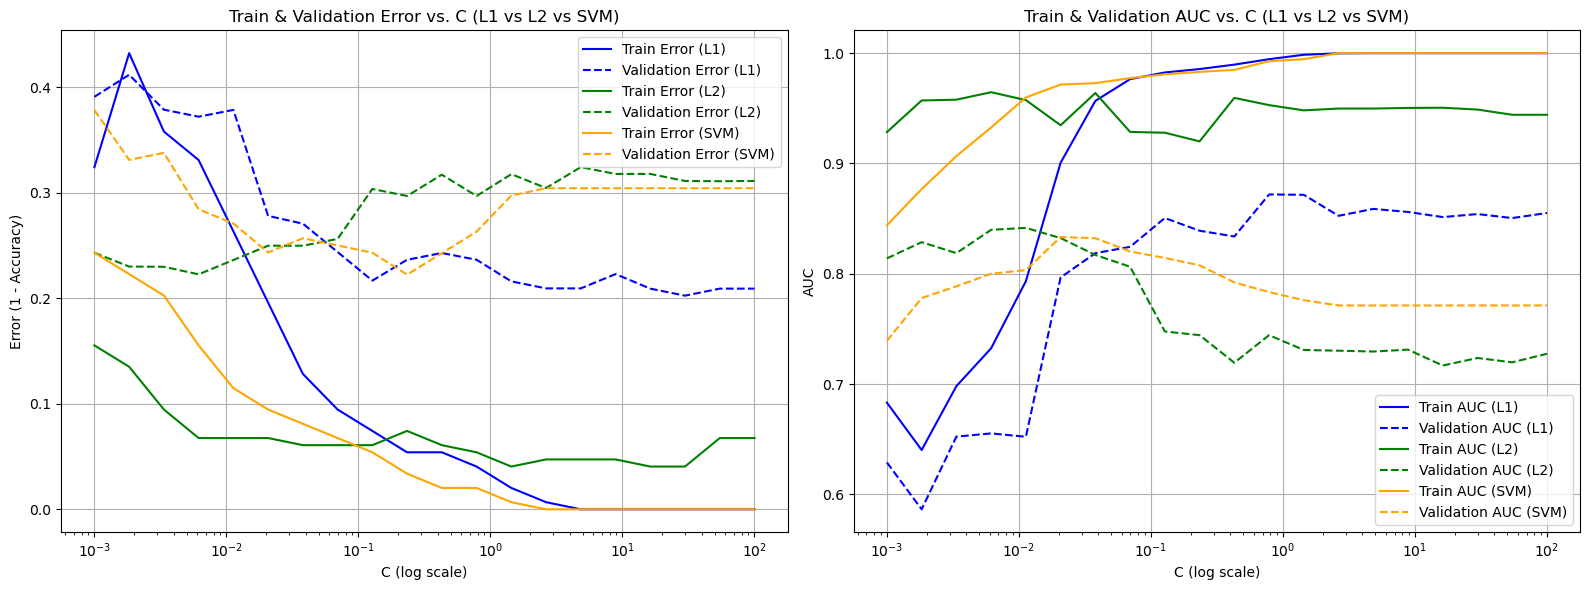

In [19]:
# Comparison plot SVM, L1 and L2
# This plot is to manually calculate the best C to limit the overfitting

C_values = np.logspace(-3, 2, 20)

# L1
train_errors_l1 = []
val_errors_l1 = []
train_auc_l1 = []
val_auc_l1 = []

# L2
train_errors_l2 = []
val_errors_l2 = []
train_auc_l2 = []
val_auc_l2 = []

# SVM
train_errors = []
val_errors = []
train_auc_list = []
cv_auc_list = []

# For-loop over C values
for C in C_values:
    # L1 Model 
    l1_model = LinearSVC(C=C, penalty='l1', loss='squared_hinge', dual=False, tol=1e-3, max_iter=10000, random_state=42)
    l1_pipe = Pipeline([('scaler', RobustScaler()), ('classifier', l1_model)])
    val_acc_l1_score = cross_val_score(l1_pipe, x_train_sig, y_train, cv=5, scoring='accuracy').mean()
    val_auc_l1_score = cross_val_score(l1_pipe, x_train_sig, y_train, cv=5, scoring='roc_auc').mean()
    l1_pipe.fit(x_train_sig, y_train)
    train_pred_l1 = l1_pipe.predict(x_train_sig)
    train_auc_l1_val = roc_auc_score(y_train, l1_pipe.decision_function(x_train_sig))

    train_errors_l1.append(1 - accuracy_score(y_train, train_pred_l1))
    val_errors_l1.append(1 - val_acc_l1_score)
    train_auc_l1.append(train_auc_l1_val)
    val_auc_l1.append(val_auc_l1_score)

    # L2 Model 
    l2_model = LinearSVC(C=C, penalty='l2', loss='squared_hinge', dual=True, tol=1e-3, max_iter=10000, random_state=42)
    l2_pipe = Pipeline([('scaler', RobustScaler()), ('classifier', l2_model)])
    val_acc_l2_score = cross_val_score(l2_pipe, x_train_sig, y_train, cv=5, scoring='accuracy').mean()
    val_auc_l2_score = cross_val_score(l2_pipe, x_train_sig, y_train, cv=5, scoring='roc_auc').mean()
    l2_pipe.fit(x_train_sig, y_train)
    train_pred_l2 = l2_pipe.predict(x_train_sig)
    train_auc_l2_val = roc_auc_score(y_train, l2_pipe.decision_function(x_train_sig))

    train_errors_l2.append(1 - accuracy_score(y_train, train_pred_l2))
    val_errors_l2.append(1 - val_acc_l2_score)
    train_auc_l2.append(train_auc_l2_val)
    val_auc_l2.append(val_auc_l2_score)

    # SVM Model (non-linear kernels) 
    svm_model = SVC(C=C, kernel=best_kernel, gamma=best_gamma,
                   degree=best_degree, coef0=best_coef0, random_state=42)

    svm_pipe = Pipeline([('scaler', RobustScaler()), ('classifier', svm_model)])
    
    # Validation performance (CV)
    val_accuracy = cross_val_score(svm_pipe, x_train_sig, y_train, cv=5, scoring='accuracy').mean()
    val_roc_auc = cross_val_score(svm_pipe, x_train_sig, y_train, cv=5, scoring='roc_auc').mean()
    
    # Train performance
    svm_pipe.fit(x_train_sig, y_train)
    train_accuracy = accuracy_score(y_train, svm_pipe.predict(x_train_sig))
    train_roc_auc = roc_auc_score(y_train, svm_pipe.decision_function(x_train_sig))

    train_errors.append(1 - train_accuracy)
    val_errors.append(1 - val_accuracy)
    train_auc_list.append(train_roc_auc)
    cv_auc_list.append(val_roc_auc)

# Create subplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error vs. C (L1, L2, SVM) 
ax[0].plot(C_values, train_errors_l1, label='Train Error (L1)', color='blue', linestyle='-')
ax[0].plot(C_values, val_errors_l1, label='Validation Error (L1)', color='blue', linestyle='--')
ax[0].plot(C_values, train_errors_l2, label='Train Error (L2)', color='green', linestyle='-')
ax[0].plot(C_values, val_errors_l2, label='Validation Error (L2)', color='green', linestyle='--')
ax[0].plot(C_values, train_errors, label='Train Error (SVM)', color='orange', linestyle='-')
ax[0].plot(C_values, val_errors, label='Validation Error (SVM)', color='orange', linestyle='--')
ax[0].set_xscale('log')
ax[0].set_xlabel('C (log scale)')
ax[0].set_ylabel('Error (1 - Accuracy)')
ax[0].set_title('Train & Validation Error vs. C (L1 vs L2 vs SVM)')
ax[0].legend()
ax[0].grid(True)

# Plot 2: AUC vs. C (L1, L2, SVM) 
ax[1].plot(C_values, train_auc_l1, label='Train AUC (L1)', color='blue', linestyle='-')
ax[1].plot(C_values, val_auc_l1, label='Validation AUC (L1)', color='blue', linestyle='--')
ax[1].plot(C_values, train_auc_l2, label='Train AUC (L2)', color='green', linestyle='-')
ax[1].plot(C_values, val_auc_l2, label='Validation AUC (L2)', color='green', linestyle='--')
ax[1].plot(C_values, train_auc_list, label='Train AUC (SVM)', color='orange', linestyle='-')
ax[1].plot(C_values, cv_auc_list, label='Validation AUC (SVM)', color='orange', linestyle='--')
ax[1].set_xscale('log')
ax[1].set_xlabel('C (log scale)')
ax[1].set_ylabel('AUC')
ax[1].set_title('Train & Validation AUC vs. C (L1 vs L2 vs SVM)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Final soft SVM classifier, based on analaysis on the three SVM classifiers: 
# without, with L1 and with L2 regulation. C is chosen from the figure above.

# Final C-values
best_C = 0.011
best_C_l1 = 0.08
best_C_l2 = 0.008

# Changing pipelines with new C values
final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma,
    degree=best_degree, coef0=best_coef0, random_state=42)
final_pipeline_soft_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model)
])

final_model_l1 = LinearSVC(C=best_C_l1, penalty='l1', loss='squared_hinge', dual=False, tol=1e-3, max_iter=10000, random_state=42)
final_pipeline_l1 = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model_l1)
])

final_model_l2 = LinearSVC(C=best_C_l2, penalty='l2', loss='squared_hinge', dual=True, tol=1e-3, max_iter=10000, random_state=42)
final_pipeline_l2 = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model_l2)
])

# Storing the results in rsults 
# Evaluating the model on test data
final_pipeline_l2.fit(x_train_sig, y_train)
y_pred_svm_l2 = final_pipeline_l2.predict(x_test[x_train_sig.columns])

# SVM does not support probability by default unless explicitly set so wee need decision function for ROC
try:
    y_scores_l2 = final_pipeline_soft_svm.decision_function(x_test[x_train_sig.columns])
    roc_l2 = roc_auc_score(y_test, y_scores_l2)
except:
    roc = np.nan


# Storing the results
# List of models with their names and pipeline objects
models = [
    ("Support Vector Machine", final_pipeline_soft_svm),
    ("Linear SVM with L1", final_pipeline_l1),
    ("Linear SVM with L2", final_pipeline_l2)
]

# Evaluate each model
for name, pipeline in models:
    # Fit the model
    pipeline.fit(x_train_sig, y_train)
    
    # Predict
    y_pred = pipeline.predict(x_test[x_train_sig.columns])
    
    # Try to get decision function scores for ROC calculation
    try:
        y_scores = pipeline.decision_function(x_test[x_train_sig.columns])
        roc = roc_auc_score(y_test, y_scores)
    except:
        roc = np.nan
    
    # Store results
    results[name] = {
        'Classifier': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc,
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }


# 7. Random forest classifier

Best Hyperparameters RF: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': False}
Validation Scores RF: [0.86666667 0.66666667 0.73333333 0.5862069  0.79310345]
Mean validation score RF: 0.7291954022988506
Train score RF:0.972972972972973

Selected Features: ['PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_hf_max', 'PREDICT_original_hf_energy', 'PREDICT_original_logf_min_sigma1', 'PREDICT_original_logf_max_sigma1', 'PREDICT_original_logf_std_sigma1', 'PREDICT_original_logf_skewness_sigma1', 'PREDICT_original_logf_kurtosis_sigma1', 'PREDICT_original_logf_range_sigma1', 'PREDICT_original_logf_quartile_range_sigma1', 'PREDICT_original_logf_std_sigma5', 'PREDICT_original_logf_quartile_range_sigma5', 'PREDICT_original_logf_skewness_sigma10', 'PREDICT_original_logf_quartile_range_sigma10', 'PREDICT_original_tf_LBP_mean_R3_P12', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDIC

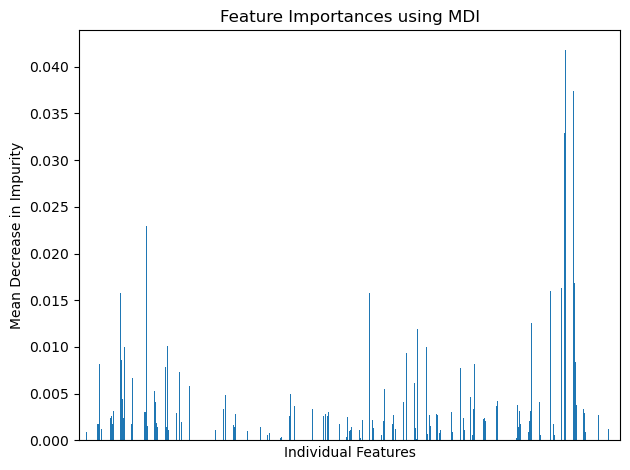

In [21]:
# Hyperparameter search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'bootstrap': [True, False]
}

# Making random forest classifier
rf = RandomForestClassifier(random_state=42)

# Performing grid search with 5-fold cross-validation and suppress verbose output
random_grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='accuracy', random_state=42)

# Fitting the grid search to the data (using x_train and y_train)
random_grid_search.fit(x_train, y_train)

# Getting the best model from the random search
best_rf = random_grid_search.best_estimator_
best_rf_selected = random_grid_search.best_estimator_ 

# Printing the best hyperparameters
print(f'Best Hyperparameters RF: {random_grid_search.best_params_}')

# Evaluating the best model on the validation set using cross-validation
best_rf.fit(x_train, y_train)
validation_rf = cross_val_score(estimator=best_rf, X=x_train, y=y_train, cv=5)
train_score_rf = best_rf.score(x_train, y_train)

print(f'Validation Scores RF: {validation_rf}')
print(f'Mean validation score RF: {np.mean(validation_rf)}')
print(f'Train score RF:{train_score_rf}\n')

# Features of importance
importances = best_rf.feature_importances_

def select_important_features(importances=importances, x_train=x_train):
    """
    Selects important features based on feature importances from RandomForestClassifier.

    Parameters:
    - model: A fitted model with a `feature_importances_` attribute (e.g., RandomForestClassifier)
    - X: The input feature DataFrame (used to get feature names)
    - threshold: Minimum importance value for a feature to be selected (default is 0.005)
    - return_filtered_data: If True, returns a DataFrame with only selected features

    Returns:
    - selected_feature_names: List of names of selected features
    - forest_importances: Pandas Series with all feature importances
    - X_selected (optional): Filtered DataFrame with selected features
    """
    

    # Assuming x_train is a DataFrame, extract the feature names from it
    feature_names = x_train.columns

    # Create a Series of feature importances
    forest_importances = pd.Series(importances, index=feature_names)

    # Making a list with the names of the selected features (those with importance > 0.005)
    selected_feature_names = [name for name, value in zip(feature_names, forest_importances) if value > 0.005]

    # Selecting the data of only the selected features (this step is optional if you choose not to filter features)
    x_train_selected = x_train[selected_feature_names]
    
    return selected_feature_names, forest_importances, x_train_selected

selected_feature_names, forest_importances, x_train_selected = select_important_features()

print(f'Selected Features: {selected_feature_names}')
print(f'Number of selected features: {len(selected_feature_names)}')

# Plotting the feature importances
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Individual Features")
plt.xticks([])
fig.tight_layout()

# Refiting the classifier on the selected features (for consistency)
best_rf_selected.fit(x_train_selected, y_train)
validation_rf_selected = cross_val_score(estimator=best_rf_selected, X=x_train_selected, y=y_train, cv=5)
train_score_rf_selected = best_rf_selected.score(x_train_selected,y_train)  # Accuracy score on training data (with selected features)

print(f'Validation Scores (selected features): {validation_rf_selected}')
print(f'Mean validation Score (selected features): {np.mean(validation_rf_selected)}')
print(f'Train score (selected features):{train_score_rf_selected}')

# Storing the results in the results dictionnary

x_test_selected = x_test[selected_feature_names]
y_pred_rf = best_rf_selected.predict(x_test_selected)
y_proba_rf = best_rf_selected.predict_proba(x_test_selected)[:, 1]  # for ROC AUC

# Compute ROC AUC
roc_rf = roc_auc_score(y_test, y_proba_rf)

# Store results
results["Random Forest"] = {
    'Classifier': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'ROC AUC': roc_rf,
    'F1 Score': f1_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf)
}

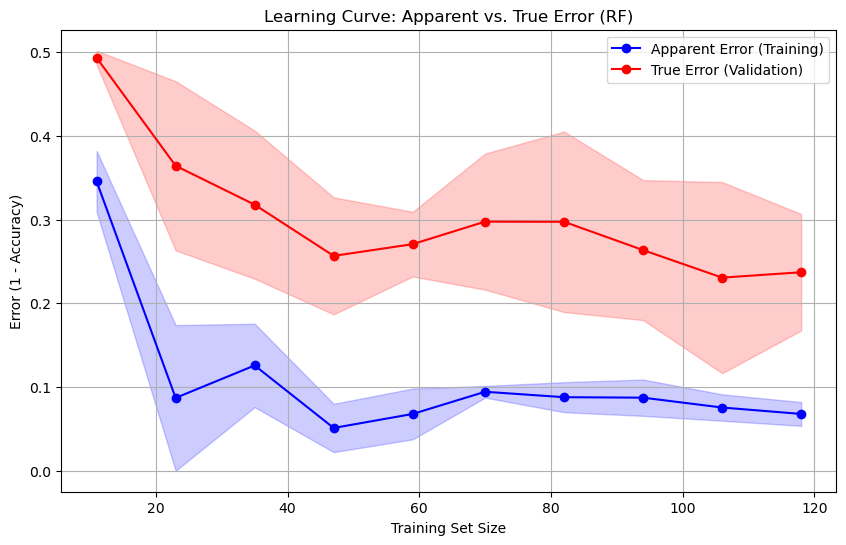

In [22]:
#Plotting RF
#  Learning curve  
best_rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(**random_grid_search.best_params_, random_state=42))
])

train_sizes, train_scores, valid_scores = learning_curve(
    best_rf_pipeline, x_train_selected, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Convert accuracy to error
train_error = 1 - train_mean
valid_error = 1 - valid_mean

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
plt.plot(train_sizes, valid_error, marker='o', label='True Error (Validation)', color='red')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, valid_error - valid_std, valid_error + valid_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error (RF)')
plt.legend()
plt.grid(True)
plt.show()

# Performance models

In [23]:
# Formula for evaluation on the best model
def evaluate_models(pipelines: dict, X=x_train_sig, y=y_train, 
                    X_rf=x_train_selected, rf_pipeline=best_rf_pipeline, 
                    X_lda=x_train_lda, lda_pipeline=lda_pipeline, 
                    X_qda=x_train_qda, qda_pipeline=qda_pipeline,
                    X_nb=x_train_nb, nb_pipeline=nb_pipeline,
                    cv=5):
    """
    Performs cross-validation for the given pipelines and prints results.

    Parameters:
    - pipelines: dictionary with model names as keys and pipeline objects as values
    - X: feature set for all models except Random Forest
    - y: target variable
    - X_rf: optional, alternative feature set for Random Forest (e.g. selected features)
    - rf_pipeline: optional, Random Forest pipeline
    - cv: number of folds for cross-validation
    """
    # cross validation on accuracy and ROC AUC
    scoring = ['accuracy', 'roc_auc']
    results = []
    
    # LDA seperately cause normally distributed and same covariant features
    lda_scores = cross_validate(lda_pipeline, X_lda, y, cv=cv, scoring=scoring)
    results.append({
        'Model': 'LDA',
        'Mean Accuracy': lda_scores['test_accuracy'].mean(),
        'Std Accuracy': lda_scores['test_accuracy'].std(),
        'Mean ROC AUC': lda_scores['test_roc_auc'].mean(),
        'Std ROC AUC': lda_scores['test_roc_auc'].std()
    })

    # QDA seperately cause normally distributed and different covariant features
    qda_scores = cross_validate(qda_pipeline, X_qda, y, cv=cv, scoring=scoring)
    results.append({
        'Model': 'QDA',
        'Mean Accuracy': qda_scores['test_accuracy'].mean(),
        'Std Accuracy': qda_scores['test_accuracy'].std(),
        'Mean ROC AUC': qda_scores['test_roc_auc'].mean(),
        'Std ROC AUC': qda_scores['test_roc_auc'].std()
    })

    # Naive Bayes seperately cause normally distributed and non correlaed features
    nb_scores = cross_validate(nb_pipeline, X_nb, y, cv=cv, scoring=scoring)
    results.append({
        'Model': 'Naive Bayes',
        'Mean Accuracy': nb_scores['test_accuracy'].mean(),
        'Std Accuracy': nb_scores['test_accuracy'].std(),
        'Mean ROC AUC': nb_scores['test_roc_auc'].mean(),
        'Std ROC AUC': nb_scores['test_roc_auc'].std()
    })

    for name, pipe in pipelines.items():
        # knn and svm both evaluated with x_train_sig
        scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring)
        results.append({
            'Model': name,
            'Mean Accuracy': scores['test_accuracy'].mean(),
            'Std Accuracy': scores['test_accuracy'].std(),
            'Mean ROC AUC': scores['test_roc_auc'].mean(),
            'Std ROC AUC': scores['test_roc_auc'].std()
        })
    # rf seperately cause trained with x_train_selected (feature importance)
    rf_scores = cross_validate(rf_pipeline, X_rf, y, cv=cv, scoring=scoring)
    results.append({
        'Model': 'Random Forest',
        'Mean Accuracy': rf_scores['test_accuracy'].mean(),
        'Std Accuracy': rf_scores['test_accuracy'].std(),
        'Mean ROC AUC': rf_scores['test_roc_auc'].mean(),
        'Std ROC AUC': rf_scores['test_roc_auc'].std()
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results).round(4)
    print(results_df)

    # Print best models
    best_acc = results_df.loc[results_df['Mean Accuracy'].idxmax()]
    best_auc = results_df.loc[results_df['Mean ROC AUC'].idxmax()]
    print(f"\nBest model by Accuracy: {best_acc['Model']} ({best_acc['Mean Accuracy']:.3f})")
    print(f"Best model by ROC AUC: {best_auc['Model']} ({best_auc['Mean ROC AUC']:.3f})")

    return best_acc, best_auc


# Results of all classifiers

In [24]:
# dit weg denk ik wss alleen beoordelen voor het model wat er het best uitkomt
results_df = pd.DataFrame(results.values())
display(results_df)

# SVM
print("Best CV Score SVM (ROC):", svm_search.best_score_) #= roc score, geen accuracy
print(f"Training score SVM: {train_score_svm}")
print("Accuracy validation SVM:", validation_accuracy_svm )
print(f'Difference training & validation SVM: {train_score_svm-np.mean(validation_accuracy_svm)}\n')


# Rf
print(f'Validation score RF (after feature selection): {np.mean(validation_rf_selected)}')
print(f"Training score RF: {train_score_rf}")
print(f'Difference between training & validation RF (before feature selection): {train_score_rf - np.mean(validation_rf)}')
print(f'Difference between training & validation RF (after feature selection): {train_score_rf - np.mean(validation_rf_selected)}')

,Classifier,Accuracy,ROC AUC,F1 Score,Precision,Recall
0,Linear Discriminant Analysis,0.552632,0.678670,0.653061,0.533333,0.842105
1,Quadratic Discriminant Analysis,0.500000,0.606648,0.344828,0.500000,0.263158
2,Naive Bayes,0.631579,0.700831,0.666667,0.608696,0.736842
3,k-Nearest Neighbors,0.473684,0.511080,0.523810,0.478261,0.578947
4,Support Vector Machine Hard,0.500000,0.570637,0.000000,0.000000,0.000000
5,Support Vector Machine,0.631579,0.747922,0.695652,0.592593,0.842105
6,Linear SVM with L1,0.736842,0.795014,0.761905,0.695652,0.842105
7,Linear SVM with L2,0.684211,0.767313,0.739130,0.629630,0.894737
8,Random Forest,0.526316,0.645429,0.550000,0.523810,0.578947


Best CV Score SVM (ROC): 0.8407619047619047
Training score SVM: 0.9656621004566209
Accuracy validation SVM: [0.83333333 0.8        0.63333333 0.75862069 0.82758621]
Difference training & validation SVM: 0.19508738781294277

Validation score RF (after feature selection): 0.7629885057471265
Training score RF: 0.972972972972973
Difference between training & validation RF (before feature selection): 0.24377757067412242
Difference between training & validation RF (after feature selection): 0.20998446722584652


# Final for-loop and performance estimate with test data


--- Split 42 ---
The shapes of the datasets for random_state=42 are:
x_train: (148, 493), x_test: (38, 493)

Number of significant features: 153
             Model  Mean Accuracy  Std Accuracy  Mean ROC AUC  Std ROC AUC
0              LDA         0.7499        0.0178        0.8137       0.0372
1              QDA         0.5664        0.0939        0.5784       0.1081
2      Naive Bayes         0.6140        0.0706        0.6526       0.0754
3              KNN         0.6761        0.0602        0.7028       0.0832
4  SVM Hard Margin         0.7170        0.0660        0.7476       0.1057
5  SVM Soft Margin         0.7221        0.0938        0.8043       0.0842
6           SVM L1         0.7492        0.0807        0.8309       0.0664
7           SVM L2         0.7639        0.0689        0.8470       0.0847
8    Random Forest         0.7630        0.0695        0.7966       0.0940

Best model by Accuracy: SVM L2 (0.764)
Best model by ROC AUC: SVM L2 (0.847)

--- Split 43 ---
The shap

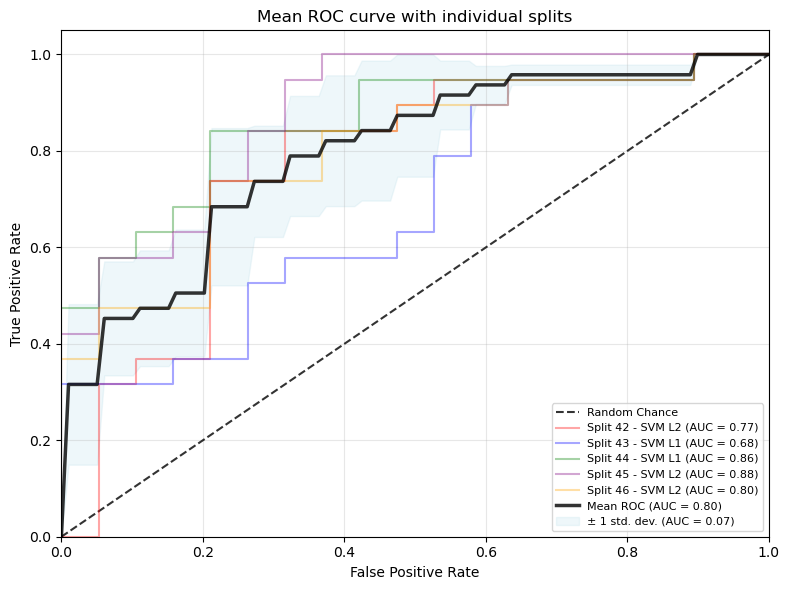

In [25]:
# Select all numerical data f(train and test) or performance estimate 
y = num_data['label']
x = num_data.drop(columns=['label'])

# Dataframes for storing results, TPR and AUC values
results_test_data = []
tprs = []
aucs = []

#  Initialize variables
mean_fpr = np.linspace(0, 1, 100)  # Common x-axis points for interpolation

# Create figure 
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, label='Random Chance') # Diagonal reference line for random chance
colors = ['red', 'blue', 'green', 'purple', 'orange'] # Colors for split curves

for i in range(42, 47):  # 5 splits
    print(f"\n--- Split {i} ---")
    # Select specific train-test split
    x_train, x_test, y_train, y_test = split_test_data(x, y, i, 0.2)

    # Select significant features for this specific split train and test data
    x_train_sig, _, _ = select_significant_features(x_train=x_train, y_train=y_train)
    selected_features_sig = x_train_sig.columns
    x_test_sig = x_test[selected_features_sig]
    
    # Select features that meet lda assumptions
    x_train_lda, x_test_lda = lda_features(features_df, x_train, x_test, y_train, verbose=False)

    # Select features that meet lda assumptions
    x_train_qda, x_test_qda = qda_features(features_df, x_train, x_test, y_train, verbose=False)

    # Select features that meet Naive Bayes assumptions
    x_train_nb, x_test_nb = nb_features(features_df, x_train, x_test, corr_threshold=0.7, verbose=False)

    # Select important features for RF train and test data
    selected_feature_imp, _, x_train_selected = select_important_features(importances=importances, x_train=x_train)
    x_test_selected = x_test[selected_feature_imp]

    # Evaluate models on this specific split
    pipelines = {
        'KNN': kn_pipeline,
        'SVM Hard Margin': svm_hard_pipeline,
        'SVM Soft Margin': final_pipeline_soft_svm,
        'SVM L1': final_pipeline_l1,
        'SVM L2': final_pipeline_l2
    }

    best_acc, best_auc = evaluate_models(pipelines, X=x_train_sig, y=y_train, 
                    X_rf=x_train_selected, rf_pipeline=best_rf_pipeline, 
                    X_lda=x_train_lda, X_qda=x_train_qda, 
                    X_nb=x_train_nb, cv=5)
    #toevoegen rf model en rest pipeline is dit erg

    # Store results for this split
    results_test_data.append({
        'Split': i,
        'Best Model (Acc)': best_acc['Model'],
        'Best Accuracy': best_acc['Mean Accuracy'],
        'Best Model (AUC)': best_auc['Model'],
        'Best AUC': best_auc['Mean ROC AUC']
    })
    
    # Select and fit best pipeline for ROC curve
    # Random Forest has different features selection so treated seperately 
    if best_auc['Model'] == 'Random Forest':
        best_pipeline = best_rf_pipeline
        best_pipeline.fit(x_train_selected, y_train)
        # Prediction for ROC curve
        y_score = best_pipeline.predict_proba(x_test_selected)[:, 1]
    
    elif best_auc['Model'] == 'LDA':
        best_pipeline = lda_pipeline
        best_pipeline.fit(x_train_lda, y_train)
        y_score = best_pipeline.predict_proba(x_test_lda)[:, 1]

    elif best_auc['Model'] == 'QDA':
        best_pipeline = qda_pipeline
        best_pipeline.fit(x_train_qda, y_train)
        y_score = best_pipeline.predict_proba(x_test_qda)[:, 1]

    elif best_auc['Model'] == 'Naive Bayes':
        best_pipeline = nb_pipeline
        best_pipeline.fit(x_train_nb, y_train)
        y_score = best_pipeline.predict_proba(x_test_nb)[:, 1]

    else:
        best_pipeline = pipelines[best_auc['Model']]
        best_pipeline.fit(x_train_sig, y_train)
        # Prediction for ROC curve
        if hasattr(best_pipeline, "predict_proba"):
            y_score = best_pipeline.predict_proba(x_test_sig)[:, 1]
        elif hasattr(best_pipeline, "decision_function"):
            y_score = best_pipeline.decision_function(x_test_sig)
        else:
            raise ValueError(f"Pipeline {best_auc['Model']} does not support predict_proba or decision_function.")
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    
    # Store AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate for smooth curve plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot individual ROC curve with a distinct color and add to legend
    plt.plot(fpr, tpr, lw=1.5, alpha=0.35, color=colors[i-42], 
             label=f'Split {i} - {best_auc["Model"]} (AUC = {roc_auc:.2f})')

# Summarize results across all splits
results_summary = pd.DataFrame(results_test_data)
print("\n=== Summary of Results Across Different Data Splits ===")
print(results_summary)

# Calculate mean and std of TPRs across all splits
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Force endpoint to 1 for visual clarity
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Calculate confidence interval bounds (mean ± std)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# Plot the mean ROC curve - make this thicker to stand out
plt.plot(mean_fpr, mean_tpr, color='black', 
         label=f'Mean ROC (AUC = {mean_auc:.2f})',
         lw=2.5, alpha=0.8)

# Add the shaded area for standard deviation
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=0.2,
                label=f'± 1 std. dev. (AUC = {std_auc:.2f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC curve with individual splits')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Display the plot
plt.tight_layout()
plt.show()